# OWA Ormonde Array Efficiency: Benchmark Evaluation Script

## Introduction
This is the model evaluation script for the [OWA-Ormonde Array Efficiency benchmark](https://thewindvaneblog.com/owa-wake-modelling-challenge-extended-to-6-offshore-wind-farms-c76d1ae645c2), following the same benchmark guidelines as the [Anholt benchmark](https://thewindvaneblog.com/the-owa-anholt-array-efficiency-benchmark-436fc538597d), as part of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).

## Load libraries

In [52]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from src.WindConditions import *
from src.BinAvrg import *  
from scipy import interpolate
from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Participants

In [54]:
n_sim = 37 # number of submited simulations + 1 (ensemble)
sims = pd.DataFrame(columns = ['ID','Plot','Highlight','Ensemble','Participant','Model Name', 'Model Type','Approach','Input','Remarks','Label'],
                   index = np.arange(0,n_sim,1))
sims.loc[0]  = ['ensemble',1,1,0,' '        ,' '          ,'ensemble'           ,'ba','wakes,wt',' '               ,'ensemble']
sims.loc[1]  = ['orm00a'  ,0,0,0,'CENER'    ,'FLORIS'     ,'Porté-Agel'         ,'ts','wakes,ref','Neutral'         ,'0_CENER_PortéAgelNeutral_ts_wakes_ref']
sims.loc[2]  = ['orm00b'  ,0,0,0,'CENER'    ,'FLORIS'     ,'Jensen'             ,'ts','wakes,ref','Neutral'         ,'0_CENER_JensenNeutral_ts_wakes_ref'   ]
sims.loc[3]  = ['orm00c'  ,0,0,0,'CENER'    ,'FLORIS'     ,'Multizone'          ,'ts','wakes,ref','Neutral'         ,'0_CENER_MultizoneNeutral_ts_wakes_ref']
sims.loc[4]  = ['orm01a'  ,0,0,1,'ProPlanEn','WakeBlaster','RANS Eddy-Vis'      ,'ts','ctrl,wt'  ,'Walney 1-4, West of Duddon Sands and Barrow added','1_ProPlanEn_WakeBlaster_ts_ctrlWF_wt']
sims.loc[5]  = ['orm01b'  ,0,0,1,'ProPlanEn','WakeBlaster','RANS Eddy-Vis'      ,'ts','wakes,wt' ,' '               ,'1_ProPlanEn_WakeBlaster_ts_wakes_wt']
sims.loc[6]  = ['orm02a'  ,0,0,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','ctrl,wt'  ,'K = 0.05'        ,'2_TUD_PARK83_ts_ctrl_wt']
sims.loc[7]  = ['orm02b'  ,1,1,1,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','wakes,wt' ,'K = 0.05'        ,'2_TUD_PARK83_ts_wakes_wt']
sims.loc[8]  = ['orm02c'  ,0,0,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','ctrl,wt'  ,'K = 0.05'        ,'2_TUD_BasPortéAgel_ts_ctrl_wt']
sims.loc[9]  = ['orm02d'  ,1,1,1,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','wakes,wt' ,'K = 0.05'        ,'2_TUD_BasPortéAgel_ts_wakes_wt']
sims.loc[10] = ['orm02h'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','scada,wt' ,'K = 0.04'        ,'2_TUD_PARK83_K0.04_ts_scada_wt']
sims.loc[11] = ['orm02i'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','scada,wt' ,'K = 0.05'        ,'2_TUD_PARK83_K0.05_ts_scada_wt']
sims.loc[12] = ['orm02j'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','scada,wt' ,'K = 0.06'        ,'2_TUD_PARK83_K0.06_ts_scada_wt']
sims.loc[13] = ['orm02k'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','scada,wt' ,'K = 0.07'        ,'2_TUD_PARK83_K0.07_ts_scada_wt']
sims.loc[14] = ['orm02l'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','wakes-corr,wt','K = 0.04'    ,'2_TUD_PARK83_K0.04_ts_wakes-corr_wt']
sims.loc[15] = ['orm02m'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','wakes-corr,wt','K = 0.05'    ,'2_TUD_PARK83_K0.05_ts_wakes-corr_wt']
sims.loc[16] = ['orm02n'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','wakes-corr,wt','K = 0.06'    ,'2_TUD_PARK83_K0.06_ts_wakes-corr_wt']
sims.loc[17] = ['orm02o'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'PARK83'             ,'ts','wakes-corr,wt','K = 0.07'    ,'2_TUD_PARK83_K0.07_ts_wakes-corr_wt']
#sims.loc[18] = ['orm02p'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','scada,wt' ,'K = 0.02'        ,'2_TUD_BasPortéAgel_K0.02_ts_scada_wt']
#sims.loc[19] = ['orm02q'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','scada,wt' ,'K = 0.03'        ,'2_TUD_BasPortéAgel_K0.03_ts_scada_wt']
#sims.loc[20] = ['orm02r'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','scada,wt' ,'K = 0.04'        ,'2_TUD_BasPortéAgel_K0.04_ts_scada_wt']
#sims.loc[21] = ['orm02s'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','scada,wt' ,'K = 0.05'        ,'2_TUD_BasPortéAgel_K0.05_ts_scada_wt']
sims.loc[18] = ['orm02t'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','wakes-corr,wt' ,'K = 0.02'   ,'2_TUD_BasPortéAgel_K0.02_ts_wakes-corr_wt']
sims.loc[19] = ['orm02u'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','wakes-corr,wt' ,'K = 0.03'   ,'2_TUD_BasPortéAgel_K0.03_ts_wakes-corr_wt']
sims.loc[20] = ['orm02v'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','wakes-corr,wt' ,'K = 0.04'   ,'2_TUD_BasPortéAgel_K0.04_ts_wakes-corr_wt']
sims.loc[21] = ['orm02w'  ,1,1,0,'TU-Delft' ,'eWakeLab'   ,'Bastankah&PortéAgel','ts','wakes-corr,wt' ,'K = 0.05'   ,'2_TUD_BasPortéAgel_K0.05_ts_wakes-corr_wt']
sims.loc[22] = ['orm05a'  ,0,0,1,'EMD'      ,'WindPro'    ,'PARK2'              ,'ts','wakes,wt' ,'TI-based'        ,'5_EMD_PARK2ti_ts_wakes_wt']
sims.loc[23] = ['orm05b'  ,0,0,1,'EMD'      ,'WindPro'    ,'PARK2'               ,'ts','wakes,wt' ,'Stability-based' ,'5_EMD_PARK2stab_ts_wakes_wt']
sims.loc[24] = ['orm07b'  ,0,0,0,'IFPEN'    ,'FarmShadow' ,'Ishihara&Qian'      ,'ts','wakes,ref',' '               ,'7_IFPEN_IsiQian_ts_wakes_ref']
sims.loc[25] = ['orm07c'  ,0,0,0,'IFPEN'    ,'FarmShadow' ,'Gaussian-Bast&Qian' ,'ts','wakes,ref',' '               ,'7_IFPEN_GaussQian_ts_wakes_ref']
sims.loc[26] = ['orm08a'  ,0,0,1,'Anonymous','WindPro'    ,'PARK2'              ,'ts','wakes,wt' ,'Cw = 0.8TI'      ,'8_PARK2_08TI_ts_wakes_wt']
sims.loc[27] = ['orm08b'  ,0,0,1,'Anonymous','WindPro'    ,'PARK'               ,'ts','wakes,wt' ,'Cw = 0.67TI'     ,'8_PARK_067TI_ts_wakes_wt']
sims.loc[28] = ['orm08c'  ,0,0,1,'Anonymous','WindPro'    ,'PARK'               ,'ts','wakes,wt' ,'Cw = 0.038'      ,'8_PARK_038_ts_wakes_wt']
sims.loc[29] = ['orm12a'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,ref','Neutral 01'      ,'12_Neutral01_ba_wakes_ref']
sims.loc[30] = ['orm12b'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,ref','Neutral 02'      ,'12_Neutral02_ba_wakes_ref']
sims.loc[31] = ['orm12c'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,ref','Stability 04'    ,'12_Stability04_ba_wakes_ref']
sims.loc[32] = ['orm12d'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,ref','Stability 06'    ,'12_Stability06_ba_wakes_ref']
sims.loc[33] = ['orm12e'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,wt','Neutral 01'      ,'12_Neutral01_ba_wakes_wt']
sims.loc[34] = ['orm12f'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,wt','Neutral 02'      ,'12_Neutral02_ba_wakes_wt']
sims.loc[35] = ['orm12g'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,wt','Stability 04'    ,'12_Stability04_ba_wakes_wt']
sims.loc[36] = ['orm12h'  ,0,0,0,'Anonymous','Anonymous'  ,'Anonymous'          ,'ba','wakes,wt','Stability 06'    ,'12_Stability06_ba_wakes_wt']
ensemble = sims.index[sims['Ensemble'] == 1].tolist()
plotresults = sims.index[sims['Plot'] == 1].tolist()
highlight = sims.index[sims['Highlight'] == 1].tolist()
tags = 'Label' 
plotresultsname = [sims[tags][x] for x in plotresults]
sims.style.set_properties(**{'text-align': 'center'})

,ID,Plot,Highlight,Ensemble,Participant,Model Name,Model Type,Approach,Input,Remarks,Label
0,ensemble,1,1,0,,,ensemble,ba,"wakes,wt",,ensemble
1,orm00a,0,0,0,CENER,FLORIS,Porté-Agel,ts,"wakes,ref",Neutral,0_CENER_PortéAgelNeutral_ts_wakes_ref
2,orm00b,0,0,0,CENER,FLORIS,Jensen,ts,"wakes,ref",Neutral,0_CENER_JensenNeutral_ts_wakes_ref
3,orm00c,0,0,0,CENER,FLORIS,Multizone,ts,"wakes,ref",Neutral,0_CENER_MultizoneNeutral_ts_wakes_ref
4,orm01a,0,0,1,ProPlanEn,WakeBlaster,RANS Eddy-Vis,ts,"ctrl,wt","Walney 1-4, West of Duddon Sands and Barrow added",1_ProPlanEn_WakeBlaster_ts_ctrlWF_wt
5,orm01b,0,0,1,ProPlanEn,WakeBlaster,RANS Eddy-Vis,ts,"wakes,wt",,1_ProPlanEn_WakeBlaster_ts_wakes_wt
6,orm02a,0,0,0,TU-Delft,eWakeLab,PARK83,ts,"ctrl,wt",K = 0.05,2_TUD_PARK83_ts_ctrl_wt
7,orm02b,1,1,1,TU-Delft,eWakeLab,PARK83,ts,"wakes,wt",K = 0.05,2_TUD_PARK83_ts_wakes_wt
8,orm02c,0,0,0,TU-Delft,eWakeLab,Bastankah&PortéAgel,ts,"ctrl,wt",K = 0.05,2_TUD_BasPortéAgel_ts_ctrl_wt
9,orm02d,1,1,1,TU-Delft,eWakeLab,Bastankah&PortéAgel,ts,"wakes,wt",K = 0.05,2_TUD_BasPortéAgel_ts_wakes_wt


## Wind farm input data 
The scada_flags dataframe indicates which timestamps have been filtered out in the quality-control process of the SCADA data. This allows to perform the evaluation on validation dataset which only contains situations where the wind farm is operating in normal conditions.

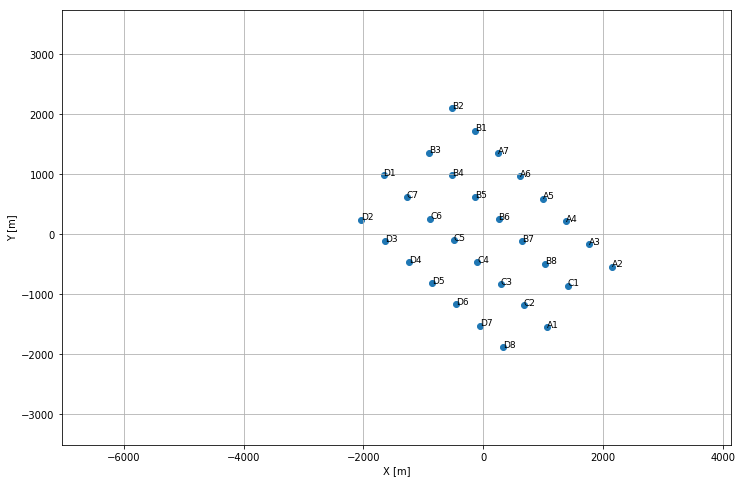

In [55]:
# setup
datefrom = time_stamp(2012,1,1,0,0,0)    # evaluation period
dateto = time_stamp(2019,2,28,23,0,0)    # evaluation period

siteID = 'Ormonde'
Hhub = 100         # hub-height
Drot = 126          # rotor diameter

# Load manufacturer's power curve 
pwr_curve_file = pd.read_csv('./inputs/Ormonde_pwc.csv')
pwr_curve_file['Power'] = pwr_curve_file['Power']/1000 # scale to MW
pwr_curve = interpolate.interp1d(pwr_curve_file['U'].values.flatten(),pwr_curve_file['Power'].values.flatten(), 
                                bounds_error = False, fill_value = 0)
# when converting power to speed use the rev_pwr_curve
###rev_pwr_curve = interpolate.interp1d(pwr_curve_file['power'].values.flatten(),pwr_curve_file['U'].values.flatten())

# Load wind farm layout data
turbines = pd.read_csv("inputs/Ormonde_layout.csv")
x_ref, y_ref = centroid(turbines[['X coordinate','Y coordinate']].values) # coordinates of wind farm centroid

plot_wf_layout(turbines['X coordinate']-x_ref, turbines['Y coordinate']-y_ref,labels = turbines['VDC ID'], figsize=(12,8))

## Read data availability flags
This file is provided to the participants so they can compute their bin-averages using the same timestamps of the validation data. Notice that:

* $min\_data\_availability$ sets the minimum availability of original (non-reconstructed) observational data, i.e. for 90%, no more than 10% is reconstructed.

* $scada\_ts$ list the time stamps that will be retained in the analysis

In [56]:
scada_flags = pd.read_csv('./inputs/Ormonde_flags.csv', index_col = 'Datetime') 
Ntot = scada_flags.shape[0]     # total number of samples in the scada dataset
min_data_availability = 90
scada_ts = flags_to_ts(scada_flags, min_data_availability) # generate a list of accepted time series

print("Hence, after applying the filter we get %d hourly samples, which is %.2f%% of the original data" % (scada_ts.shape[0],scada_ts.shape[0]*100/Ntot))

Hence, after applying the filter we get 28941 hourly samples, which is 51.40% of the original data


## Wind conditions from mesoscale input data
In the absence of an *undisturbed* met mast, the wind farm centroid is used as reference site to define wind conditions and classify the wind climate in terms of wind direction sectors and stability classes. This site has also been used as the center of the innermost domain in the WRF set-up.

**Fig 1. Distributions at zref for all data (above) and retained for validation (below)**

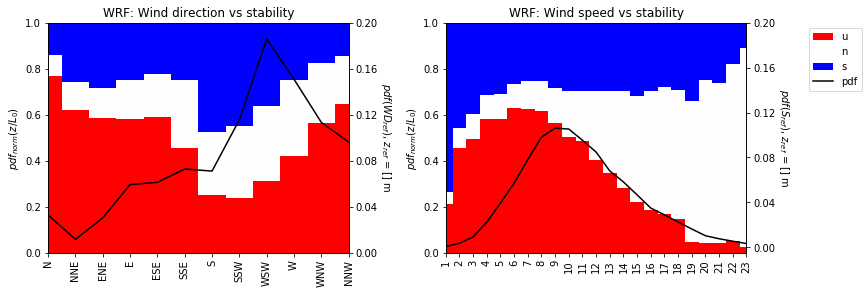

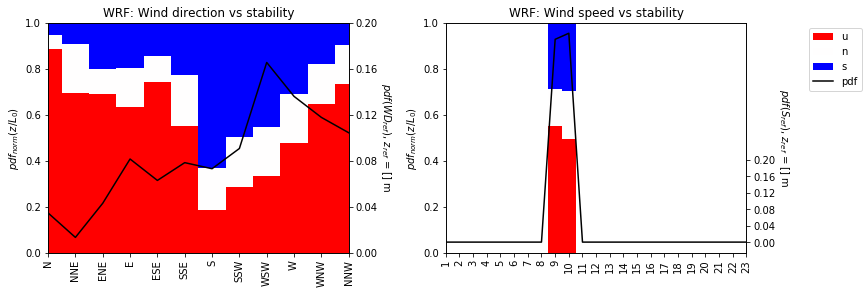

In [57]:
# Define bins to classify wind conditions 
Sbins = np.array([8,10])              # around the maximum of the trust coefficient 
WDbins = np.arange(-15.,360.+15.,30)  # wind direction bins (12 sectors)
WDbins_label = ['N','NNE','ENE','E','ESE','SSE',
                'S','SSW','WSW','W','WNW','NNW']
zLbins = [-0.2,-0.02, 0.02, 0.2]      # 3 stability bins
zLbins_label = ['u','n','s']

# interpolate to reference height
zref = Hhub         # [m]

# Load mesoscale data from the referent site (time-height profiles)
mast = WindConditions('./inputs/Ormonde_Wakes_ref_corrected.nc', siteID, datefrom, dateto,'point')

#init the bin averaging class
bin_avrg = BinAvrg(siteID,datefrom, dateto, WDbins, WDbins_label, zLbins, zLbins_label,turbines['VDC ID'],sims["ID"].values)

#filter for wind speed bin
scada_ts = bin_avrg.filter_s(mast, [], scada_ts, Sbins)

# Compute and plot distributions 
N_WDzL,_,_,_,_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,[])

# after filtering
mast.reduce_to_ts(scada_ts,'point')
N_WDzL_speed,_,_,_,S_WDzL_speed = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,[])

figcaption = ("**Fig 1. Distributions at zref for all data (above) and retained for validation (below)**")
display(Markdown(figcaption))

In [58]:
Nval = N_WDzL_speed.sum().sum() # total number of samples in the validation dataset
print("Hence, after filtering for the wind speed, stability and direction bins, there are %d hourly samples (%.2f%% of the original data) distributed according to the following validation bins:" % (Nval, Nval*100/Ntot))
N_WDzL_speed

Hence, after filtering for the wind speed, stability and direction bins, there are 5686 hourly samples (10.10% of the original data) distributed according to the following validation bins:


,u,n,s
N,174.0,12.0,10.0
NNE,52.0,16.0,7.0
ENE,168.0,27.0,49.0
E,293.0,78.0,92.0
ESE,265.0,40.0,52.0
SSE,245.0,98.0,102.0
S,77.0,76.0,262.0
SSW,146.0,113.0,256.0
WSW,313.0,203.0,425.0
W,370.0,163.0,240.0


Now we load the mesoscale data interpolated at the turbine positions to generate reference power data that will be used in the definition of array efficiency.

In [59]:
# Load mesoscale data at turbine positions (time-series at hub-height)
# control input
f = netCDF4.Dataset('./inputs/Ormonde_Control_WindTurbines.nc', 'r')
mesoctrl_ts_windspeed = pd.DataFrame(
            (f.variables['U'][:].data**2 + f.variables['V'][:].data**2)**0.5, 
            index = f.variables['Times'][:].data)
mesoctrl_ts_windspeed = restrict_to_ts(mesoctrl_ts_windspeed, scada_ts)
mesoctrl_ts_power = mesoctrl_ts_windspeed.transform(pwr_curve) # convert to power

f = netCDF4.Dataset('./inputs/Ormonde_Wakes_WindTurbines_corrected.nc', 'r')
meso_ts_windspeed = pd.DataFrame(
            (f.variables['U'][:].data**2 + f.variables['V'][:].data**2)**0.5, 
            index = f.variables['Times'][:].data)
meso_ts_windspeed = restrict_to_ts(meso_ts_windspeed, scada_ts)
meso_ts_power = meso_ts_windspeed.transform(pwr_curve) # convert to power

# Bias-corrected mesoscale data
mesocorr_ts_windspeed = pd.DataFrame(
            (f.variables['U_corr'][:].data**2 + f.variables['V_corr'][:].data**2)**0.5, 
            index = f.variables['Times'][:].data)
mesocorr_ts_windspeed = restrict_to_ts(mesocorr_ts_windspeed, scada_ts)
mesocorr_ts_power = mesocorr_ts_windspeed.transform(pwr_curve) # convert to power

Create mapping of time stamps per wind direction and stability bins

In [60]:
# create mapping, 
ts_bin_map = bin_avrg.create_ts_to_bin_map(mast, [], scada_ts)
# where ts_bin_map[0][0] provides indices to samples in the N-u bin  

# Compute bin-averaged (and std) quantities,
meso_P, meso_P_std = bin_avrg.compute_mean(meso_ts_power, ts_bin_map)
# where a 3D array is created, e.g. meso_p.loc['ANHA01'].loc['N'].loc['u'] provides the mean power at 
# turbine A01 for North sector in unstable conditions
meso_S, meso_S_std = bin_avrg.compute_mean(meso_ts_windspeed, ts_bin_map)

# Control mesoscale data
mesoctrl_P, mesoctrl_P_std = bin_avrg.compute_mean(mesoctrl_ts_power, ts_bin_map)
mesoctrl_S, mesoctrl_S_std = bin_avrg.compute_mean(mesoctrl_ts_windspeed, ts_bin_map)

# Bias-corrected mesoscale data
mesocorr_P, mesocorr_P_std = bin_avrg.compute_mean(mesocorr_ts_power, ts_bin_map)
mesocorr_S, mesocorr_S_std = bin_avrg.compute_mean(mesocorr_ts_windspeed, ts_bin_map)

## Load simulation data

In [61]:
# Loop through the submitted simulation data files and categorize them according to Table 1
sim_ts = []
sim_P = bin_avrg.array_init(('sim', 'wt','wd','zL'))
sim_P_std = bin_avrg.array_init(('sim', 'wt','wd','zL'))
# where sim_P.loc['anh01'].loc['ANHA01'].loc['N'].loc['u'] provides the mean power for anh01 simulation at 
# turbine A01 for North sector in unstable conditions

for isim in range(1,n_sim):
    file_name = './outputs/'+ sims["ID"][isim] +'.csv'
    print(file_name)
    ts = p = p_std = None
    if sims["Approach"][isim] == 'ts': 
        ts = pd.read_csv(file_name, index_col = 'time')    # read .csv output files
        p, p_std = bin_avrg.compute_mean(ts, ts_bin_map)   # from time-series to bin-averaged quantities
        # clean up the time series data and apply the scada_ts filter
        ts = restrict_to_ts(ts, scada_ts)
    else:
        p = bin_avrg.read_ba_file(file_name)
    sim_ts.append(ts)
    sim_P[isim] = p
    sim_P_std[isim] = p_std

# Compute ensemble
sim_P[0] = sim_P[ensemble].mean(axis=0)
sim_P_std[0] = sim_P_std[ensemble].mean(axis=0)
print('Ensemble generated based on: ' + ', '.join(sims.loc[ensemble]["Label"].tolist()))

./outputs/orm00a.csv
./outputs/orm00b.csv
./outputs/orm00c.csv
./outputs/orm01a.csv
./outputs/orm01b.csv
./outputs/orm02a.csv
./outputs/orm02b.csv
./outputs/orm02c.csv
./outputs/orm02d.csv
./outputs/orm02h.csv
./outputs/orm02i.csv
./outputs/orm02j.csv
./outputs/orm02k.csv
./outputs/orm02l.csv
./outputs/orm02m.csv
./outputs/orm02n.csv
./outputs/orm02o.csv
./outputs/orm02t.csv
./outputs/orm02u.csv
./outputs/orm02v.csv
./outputs/orm02w.csv
./outputs/orm05a.csv
./outputs/orm05b.csv
./outputs/orm07b.csv
./outputs/orm07c.csv
./outputs/orm08a.csv
./outputs/orm08b.csv
./outputs/orm08c.csv
./outputs/orm12a.csv
./outputs/orm12b.csv
./outputs/orm12c.csv
./outputs/orm12d.csv
./outputs/orm12e.csv
./outputs/orm12f.csv
./outputs/orm12g.csv
./outputs/orm12h.csv
Ensemble generated based on: 1_ProPlanEn_WakeBlaster_ts_ctrlWF_wt, 1_ProPlanEn_WakeBlaster_ts_wakes_wt, 2_TUD_PARK83_ts_wakes_wt, 2_TUD_BasPortéAgel_ts_wakes_wt, 5_EMD_PARK2ti_ts_wakes_wt, 5_EMD_PARK2stab_ts_wakes_wt, 8_PARK2_08TI_ts_wakes_wt, 

## Load validation data
To increase the data availability, a machine learning algorithm has been applied to recover data from turbines that are not working in nominal conditions from others that do. Then, the "gap-filled" observational data is loaded and the scada_ts filter applied to syncronize with the simulation data for validation.

In [62]:
try:
    obs_ts = pd.read_csv('./observations/Dudgeon_obs.csv', index_col = 'time') 
    obs_P, obs_P_std = bin_avrg.compute_mean(obs_ts, ts_bin_map)  
    # clean up the time series data and apply the scada_ts filter
    obs_ts = restrict_to_ts(obs_ts, scada_ts)
    validation_data = True
except IOError:
    print ("No validation data available")
    validation_data = False

No validation data available


If no validation data is available, do code to code comparison by selecting a reference simulation to compare against:

In [63]:
validation = True # "False" if no validation data is available or you want to do code-to-code comparison 
benchmark = 0      # benchmark simulation for code-to-code  

if (validation and validation_data):
    print ("Your reference series is observations")
    bench_P = obs_P
    bench_P_std = obs_P_std
else: 
    print ("Your benchmark series is %s " % (sims["Label"][benchmark]))
    bench_P = sim_P[benchmark]
    bench_P_std = sim_P_std[benchmark]

Your benchmark series is ensemble 


## Mesoscale bias correction
The input mesoscale data comes with an inherent bias that we can try to mitigate by using local observations. In the absence of a met mast, the power data can serve as a proxy to obtain the wind resource through the inverse of the power curve. This is done at the turbines that experience *free-stream* conditions at the boundary of the array, which depends on the wind direction. The *define_freestream(points,WD)* function uses the reference wind direction and determines which turbines in the wind farm boundary do not have upstream wind turbines within a 45º sector. Turbines inside the array are associated with the wind resource of the nearest turbine in free-stream conditions. Then, the mesoscale bias correction at each turbine location $A_{M,i}$ is the ratio between the observed freestream power $P_{obsfree,i}$ and that simulated from mesoscale $P(S_i)$:  

$$ A_{M,i} = \frac{P_{obsfree,i}}{P(S_{i})} \sim \left( \frac{S_{obs,i}}{S_{i}} \right)^{3} $$

In [64]:
try:
    # Local (wind turbine) mesoscale bias correction
    obs_Pfree_ts = pd.read_csv('./observations/Ormonde_Pfree.csv', index_col = 'time')
    obs_Pfree = restrict_to_ts(obs_Pfree_ts, scada_ts)
    obs_Pfree, obs_Pfree_std = bin_avrg.compute_mean(obs_Pfree, ts_bin_map)
    Am = obs_Pfree/meso_P   
    #Am.to_netcdf('./inputs/Dudgeon_Am.nc')
except IOError:
    Am = xr.open_dataset('./inputs/Ormonde_Am.nc')
    print("No freestream data is available")

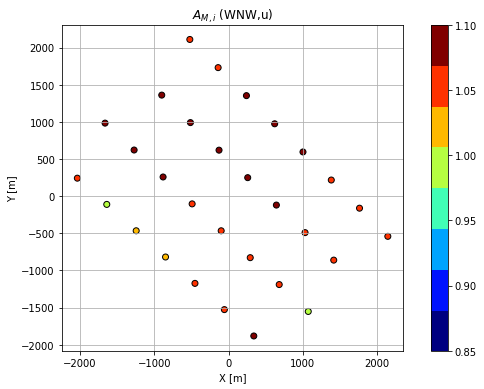

In [65]:
WDbin = 'WNW' # select wind direction sector
zLbin = 'u'   # select stability

data = Am.loc[:,WDbin,zLbin].to_pandas()
cmap=plt.cm.get_cmap('jet',8)
fig, ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(turbines['X coordinate']-x_ref,turbines['Y coordinate']-y_ref
                     ,marker='o',c=data,cmap=cmap,edgecolors ='k', vmin = 0.85, vmax=1.1)
plt.colorbar(sc,ax=ax)
ax.set_aspect(1.0)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title(r'$A_{M,i}$ ('+ WDbin + ',' + zLbin + ')')
ax.grid()

Total mesoscale bias correction = 1.0443793520740323


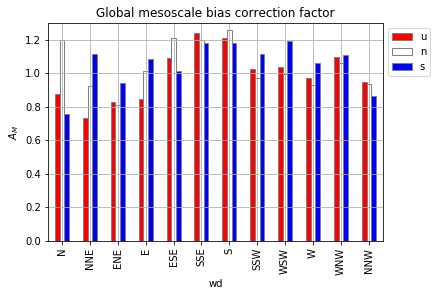

In [66]:
# Average over all turbines to obtain the global mesoscale bias correction factor
Am_global = Am.mean(axis=0)
Am_global_df = Am_global.to_dataframe(name = 'Am').unstack()
Am_global_df.columns = Am_global_df.columns.get_level_values(1)
Am_global_df = Am_global_df[['u','n','s']]
fig, ax = plt.subplots()
Am_global_df.reindex(index = WDbins_label).plot.bar(grid=1, title = 'Global mesoscale bias correction factor', colormap = 'bwr_r', edgecolor = 'grey', ax=ax)
ax.set_ylabel(r'$A_M$')
ax.legend(['u', 'n', 's'], bbox_to_anchor=(1.0, 1.0));
ax.set_ylim(0,1.3)

Am_total = (Am_global_df*N_WDzL/N_WDzL.sum().sum()).sum().sum()
print('Total mesoscale bias correction = '+ str(Am_total))

In [67]:
# Wind farm gross power  
meso_P_sum = np.sum(meso_P, axis = 0)           # mesoscale "wakes"
mesoctrl_P_sum = np.sum(mesoctrl_P, axis = 0)   # mesoscale "control"
mesocorr_P_sum = np.sum(mesocorr_P, axis = 0)   # bias-corrected mesoscale
obs_Pfree_sum = np.sum(obs_Pfree, axis = 0)     # observations 

# Calculate gross power using define_freestream method and compute Afree for each simulation
sim_Pfree = bin_avrg.array_init(('sim', 'wt','wd','zL'))
Afree_sim = bin_avrg.array_init(('sim', 'wt','wd','zL'))
points = turbines[['X coordinate','Y coordinate']].values
n_wt, n_wd,n_zL = sim_P[0].shape
for isim in range(n_sim):
    for wd in range(n_wd):
        for zL in range(n_zL):
            WD = 0.5*(WDbins[wd] + WDbins[wd+1])
            freestream = define_freestream(points,WD)
            f1 = interpolate.NearestNDInterpolator(points[freestream], sim_P[isim][freestream,wd,zL].values)
            sim_Pfree[isim][:,wd,zL] = f1(points)
    if ("wakes-corr" in sims['Input'][isim]):
        Afree_sim[isim] = sim_Pfree[isim]/mesocorr_P
    elif ("ctrl" in sims['Input'][isim]):
        Afree_sim[isim] = sim_Pfree[isim]/mesoctrl_P
    elif ("scada" in sims['Input'][isim]):
        Afree_sim[isim] = sim_Pfree[isim]/obs_Pfree
    else:
        Afree_sim[isim] = sim_Pfree[isim]/meso_P   

This bin has 203.0 samples


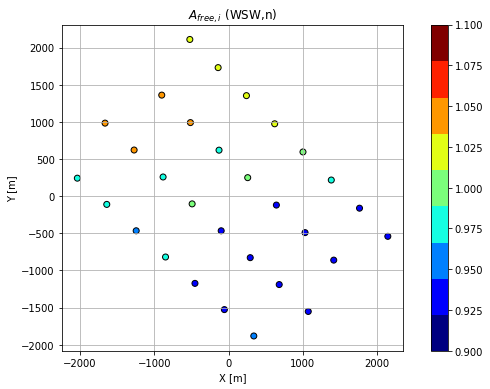

In [68]:
sim = 'orm02b' # select simulation to plot
# Print freestream bias
WDbin = 'WSW' # select wind direction sector
zLbin = 'n'   # select stability

Afree_sim_df = Afree_sim.loc[sim].loc[:,WDbin,zLbin].to_pandas()
cmap=plt.cm.get_cmap('jet',9)
fig, ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(turbines['X coordinate']-x_ref,turbines['Y coordinate']-y_ref
                     ,marker='o',c=Afree_sim_df,cmap=cmap,edgecolors ='k', vmin = 0.9, vmax=1.1)
plt.colorbar(sc,ax=ax)
ax.set_aspect(1.0)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title(r'$A_{free,i}$ ('+ WDbin + ',' + zLbin + ')')
ax.grid()

print('This bin has {} samples'.format(N_WDzL_speed.loc[WDbin,zLbin]))

Total freestream bias correction = 0.9908933450737386


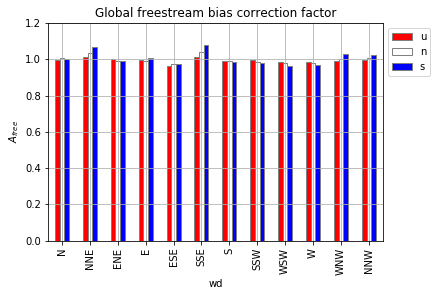

In [69]:
# Average over all turbines to obtain the global freestream bias
Afree_sim_global = Afree_sim.loc[sim].mean(axis=0).drop('sim')
Afree_sim_global_df = Afree_sim_global.to_dataframe(name = 'Afree').unstack()
Afree_sim_global_df.columns = Afree_sim_global_df.columns.get_level_values(1)
Afree_sim_global_df = Afree_sim_global_df[['u','n','s']]
fig, ax = plt.subplots()
Afree_sim_global_df.reindex(index = WDbins_label).plot.bar(grid=1, title = 'Global freestream bias correction factor', colormap = 'bwr_r', edgecolor = 'grey', ax=ax)
ax.set_ylabel(r'$A_{free}$')
ax.legend(['u', 'n', 's'], bbox_to_anchor=(1.0, 1.0));
ax.set_ylim(0,1.2)

Afree_sim_total = (Afree_sim_global_df*N_WDzL/N_WDzL.sum().sum()).sum().sum()
print('Total freestream bias correction = '+ str(Afree_sim_total))

### Visualize layout for a particular timestamp

In [70]:
time0 = scada_ts[45]  
# 45 : NW farm-farm effects visible and not fully captured by obs_Pfree missing on the longitudinal gradients
datetime0 = datetime.datetime.fromtimestamp(time0)
Pscada = obs_ts.loc[time0]
Pfree = obs_Pfree_ts.loc[time0]
Pmeso = meso_ts_power.loc[time0]
Psim = sim_ts[7].loc[time0]
WDref = mast.data['WD'].loc[datetime0][0]
Sref = mast.data['S'].loc[datetime0][0]

2012-03-30 04:00:00      WDref = 334.35, Sref = 9.16


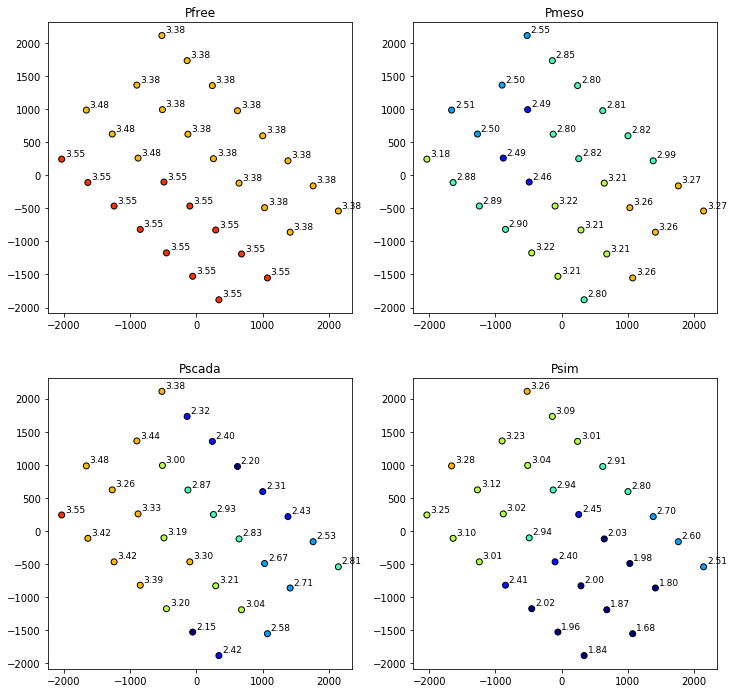

In [71]:
vmin = 2
vmax = 4
x = turbines['X coordinate']-x_ref
y = turbines['Y coordinate']-y_ref
cmap=plt.cm.get_cmap('jet',8)
fig, ax = plt.subplots(2,2,figsize=(12,12))

sc = ax[0,0].scatter(x,y,marker='o',c=Pfree,cmap=cmap,edgecolors ='k', vmin = vmin, vmax=vmax)
labels = list(map("{:.2f}".format,Pfree.values))
for i in range(len(labels)):
    ax[0,0].text(x[i]+50, y[i]+50, labels[i], fontsize=9) 
ax[0,0].set_aspect(1.0)
ax[0,0].set_title('Pfree')

sc = ax[0,1].scatter(x,y,marker='o',c=Pmeso,cmap=cmap,edgecolors ='k', vmin = vmin, vmax=vmax)
labels = list(map("{:.2f}".format,Pmeso.values))
for i in range(len(labels)):
    ax[0,1].text(x[i]+50, y[i]+50, labels[i], fontsize=9) 
ax[0,1].set_aspect(1.0)
ax[0,1].set_title('Pmeso')

sc = ax[1,0].scatter(x,y,marker='o',c=Pscada,cmap=cmap,edgecolors ='k', vmin = vmin, vmax=vmax)
labels = list(map("{:.2f}".format,Pscada.values))
for i in range(len(labels)):
    ax[1,0].text(x[i]+50, y[i]+50, labels[i], fontsize=9) 
ax[1,0].set_aspect(1.0)
ax[1,0].set_title('Pscada')

sc = ax[1,1].scatter(x,y,marker='o',c=Psim,cmap=cmap,edgecolors ='k', vmin = vmin, vmax=vmax)
labels = list(map("{:.2f}".format,Psim.values))
for i in range(len(labels)):
    ax[1,1].text(x[i]+50, y[i]+50, labels[i], fontsize=9) 
ax[1,1].set_aspect(1.0)
ax[1,1].set_title('Psim')
#plt.colorbar(sc,ax=ax3)
print('{}      WDref = {:.2f}, Sref = {:.2f}'.format(datetime0, WDref,Sref))

## Compute quantities of interest and metrics
*Array efficiency* for a wind turbine is defined as:

$$ \eta_{i} = \frac{P_i}{P(S_i)} $$

and for the whole wind farm as: 

$$ \eta = \frac{\sum_{i}P_i}{\sum_{i}P(S_i)} $$

where $P_i$ is the power of turbine $i$, observed or simulated, and $P(S_i)$ is the theoretical power from the power curve computed at the background (mesoscale) wind speed $S_i$ at each turbine position.  

Performance is measured in terms of the $BIAS$ and mean absolute error ($MAE$):

$$ BIAS = \eta_{bench} - \eta_{sim} $$ 
$$ MAE = |\eta_{bench} - \eta_{sim}| $$

where the benchmark data come from either observations or another simulation (typically the ensemble). The metrics are calculated for each turbine and wind farm per bin and integrated for the whole wind distribution. Hence:
* Positive *BIAS* means under-prediction of array efficiency, i.e. the model predicts larger wake losses 
* Negative *BIAS* means over-prediction of array efficiency, i.e. the model predeicts smaller wake losses
* *MAE* avoids the error compensation that takes place in the *BIAS* 

In [72]:
#init the arrays
# Wind farm metrics
sim_eta = bin_avrg.array_init(('sim', 'wd','zL'))
bias = bin_avrg.array_init(('sim', 'wd','zL'))
mae = bin_avrg.array_init(('sim', 'wd','zL'))
sim_eta_tot = bin_avrg.array_init(('sim',))
bias_tot = bin_avrg.array_init(('sim',))
mae_tot = bin_avrg.array_init(('sim',))
len_array = np.vectorize(len)

Nmin = 25 # Minimum number of samples in a bin to contribute to the total bias/mae
bin_sizes = len_array(ts_bin_map)
bin_sizes[N_WDzL_speed < Nmin] = 0 
sum_bin_sizes = bin_sizes.sum()

# Wind turbine metrics
sim_eta_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))
bias_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))
mae_wt = bin_avrg.array_init(('sim', 'wt','wd','zL'))

# Wind farm gross power  
meso_P_sum = np.sum(meso_P, axis = 0)           # mesoscale "wakes"
mesoctrl_P_sum = np.sum(mesoctrl_P, axis = 0)   # mesoscale "control"
mesocorr_P_sum = np.sum(mesocorr_P, axis = 0)   # bias-corrected mesoscale
obs_Pfree_sum = np.sum(obs_Pfree, axis = 0)     # observations 

# Benchmark series to compute metrics against
if (validation and validation_data):      # observations are available
    bench_eta = 100*np.sum(bench_P,axis=0) / obs_Pfree_sum  # wind farm
    bench_eta_wt = 100*bench_P / obs_Pfree                  # wind turbines 
else:  # compare against a benchmark simulation
    bench_eta = 100*np.sum(bench_P,axis=0) / sim_Pfree[benchmark].drop('sim').sum(axis = 0)
    bench_eta_wt = 100*bench_P / sim_Pfree[benchmark].drop('sim')
    
#    if ("wakes-corr" in sims['Input'][benchmark]):
#        bench_eta = 100*np.sum(bench_P,axis=0) / mesocorr_P_sum
#        bench_eta_wt = 100*bench_P / mesocorr_P 
#    elif ("ctrl" in sims['Input'][benchmark]):
#        bench_eta = 100*np.sum(bench_P,axis=0) / mesoctrl_P_sum
#        bench_eta_wt = 100*bench_P / mesoctrl_P 
#    elif ("scada" in sims['Input'][benchmark]):
#        bench_eta = 100*np.sum(bench_P,axis=0) / obs_Pfree_sum
#        bench_eta_wt = 100*bench_P / obs_Pfree 

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for isim in range(n_sim):
        sim_eta[isim] = 100*np.sum(sim_P[isim],axis=0) / sim_Pfree[isim].drop('sim').sum(axis = 0)
        sim_eta_wt[isim] = 100*sim_P[isim] / sim_Pfree[isim].drop('sim')
#        if ("wakes-corr" in sims['Input'][isim]):
#            sim_eta[isim] = 100*np.sum(sim_P[isim],axis=0) / mesocorr_P_sum
#            sim_eta_wt[isim] = 100*sim_P[isim] / mesocorr_P 
#        elif ("ctrl" in sims['Input'][isim]):
#            sim_eta[isim] = 100*np.sum(sim_P[isim],axis=0) / mesoctrl_P_sum
#            sim_eta_wt[isim] = 100*sim_P[isim] / mesoctrl_P 
#        elif ("scada" in sims['Input'][isim]):
#            sim_eta[isim] = 100*np.sum(sim_P[isim],axis=0) / obs_Pfree_sum
#            sim_eta_wt[isim] = 100*sim_P[isim] / obs_Pfree 
#        else:
#            sim_eta[isim] = 100*np.sum(sim_P[isim],axis=0) / meso_P_sum
#            sim_eta_wt[isim] = 100*sim_P[isim] / meso_P 
        sim_eta[isim] = sim_eta[isim].where(sim_eta[isim]>0)  # nan when there is no data (sim_P = nan) 
        bias[isim] = sim_eta[isim] - bench_eta
        mae[isim] = np.absolute(bias[isim])
        bias_wt[isim] = sim_eta_wt[isim] - bench_eta_wt
        mae_wt[isim] = np.absolute(bias_wt[isim])
        if np.isnan(sim_P[isim]).any(): # if there are no result for all bins don't compute the total values
            sim_eta_tot[isim] = np.nan
            bias_tot[isim] = np.nan
            mae_tot[isim] = np.nan
        else:
            sim_eta_tot[isim] = (sim_eta[isim]*bin_sizes).sum()/sum_bin_sizes
            bias_tot[isim] = (bias[isim]*bin_sizes).sum()/sum_bin_sizes
            mae_tot[isim] = (mae[isim]*bin_sizes).sum()/sum_bin_sizes  

## Plot results

### Wind farm metrics


,sim,ArrayEff[%],BIAS[%],MAE[%]
0,ensemble,78.456970,0.000000,0.000000
7,2_TUD_PARK83_ts_wakes_wt,75.826282,-2.630688,3.696349
9,2_TUD_BasPortéAgel_ts_wakes_wt,77.529052,-0.927918,1.499957
10,2_TUD_PARK83_K0.04_ts_scada_wt,78.093366,-0.363603,3.705200
11,2_TUD_PARK83_K0.05_ts_scada_wt,77.485036,-0.971934,2.559238
12,2_TUD_PARK83_K0.06_ts_scada_wt,79.344148,0.887178,2.840692
13,2_TUD_PARK83_K0.07_ts_scada_wt,80.165323,1.708353,2.060487
14,2_TUD_PARK83_K0.04_ts_wakes-corr_wt,76.025112,-2.431858,4.233689
15,2_TUD_PARK83_K0.05_ts_wakes-corr_wt,75.329795,-3.127174,3.721894
16,2_TUD_PARK83_K0.06_ts_wakes-corr_wt,77.285528,-1.171442,3.207155


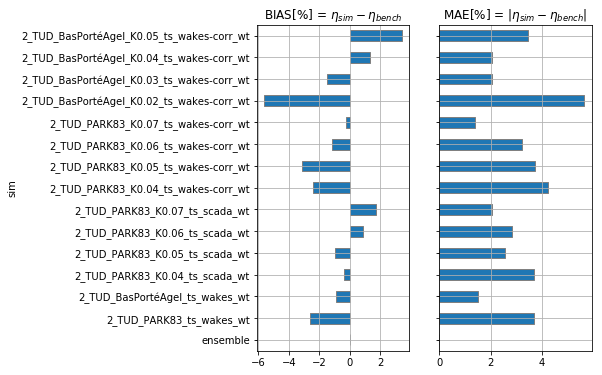

In [73]:
# Compute total wind farm metrics 
Metrics = pd.DataFrame(np.zeros((n_sim,4)),
                       columns = ['sim','ArrayEff[%]','BIAS[%]','MAE[%]'],
                       index = sims.index) #sims[tags]
for isim in range(n_sim):
    Metrics.loc[isim,'sim'] = sims[tags][isim] #sims[tags][isim]
    Metrics.loc[isim,'ArrayEff[%]'] = sim_eta_tot[isim] #sims[tags][isim]
    Metrics.loc[isim,'BIAS[%]'] = bias_tot[isim]
    Metrics.loc[isim,'MAE[%]'] = mae_tot[isim]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all',figsize=(6,6))
Metrics.iloc[plotresults].plot.barh(x = 'sim', y = 'BIAS[%]', ax = ax[0], rot=0, grid=1, edgecolor = 'grey', 
                                    title='BIAS[%] = $\eta_{sim}-\eta_{bench}$',legend=False); #colormap = 'bwr'
Metrics.iloc[plotresults].plot.barh(x = 'sim', y = 'MAE[%]' , ax = ax[1], rot=0, grid=1, edgecolor = 'grey', 
                                    title='MAE[%] = |$\eta_{sim}-\eta_{bench}$|',legend=False); #colormap = 'bwr'
Metrics.iloc[plotresults]

### Bin-averaged metrics


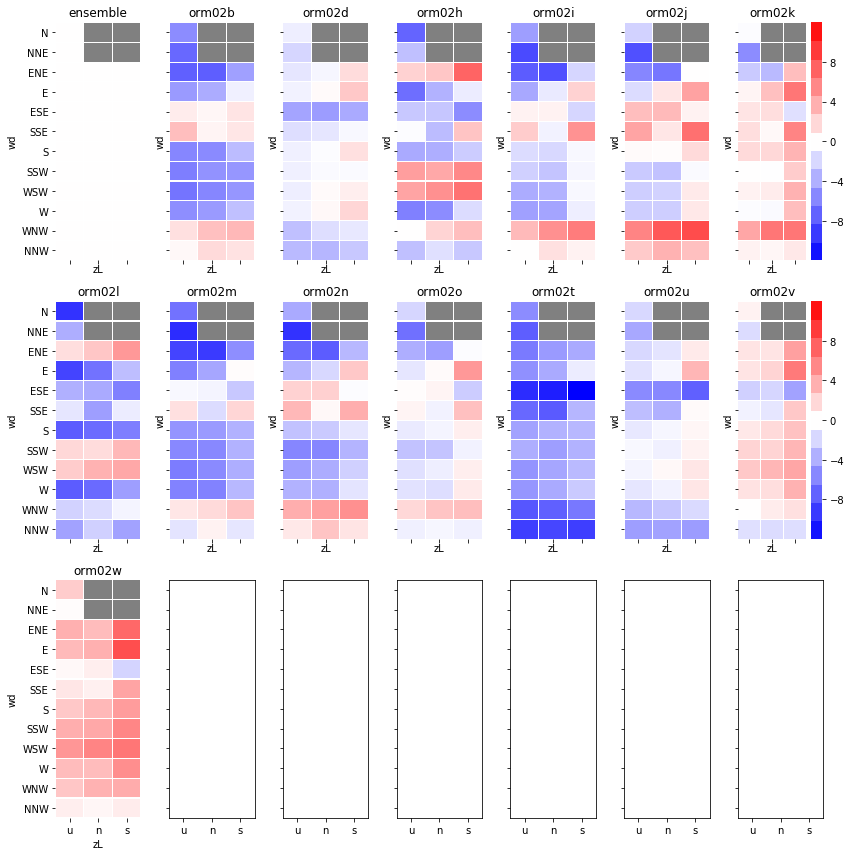

**Heat map of array efficiency BIAS [%]**

In [74]:
figcaption = "**Heat map of array efficiency BIAS [%]**"
title = ""#"_BIAS[%]"
bin_avrg.plot_heatmaps(bias[plotresults].where((sim_eta[0]>0) & (N_WDzL_speed >= Nmin)), sub_plt_size = (1.7,4),n_plot_cols = 7, 
                       figcaption = figcaption, title=title)

#sim_name, bias.max(axis=1) # Compute maximum per stability

Integrate along wind direction to obtain metrics dependency on stability.
* Positive *BIAS* (under-prediction) in unstable conditions indicate that models are predicting larger wake losses than observations due to wakes decaying slower than they should (under-dissipative conditions). 
* Conversely, negative *BIAS* (neutral and stable conditions) indicate over-dissipative conditions leading to faster wake recovery 
* If input turbulence from mesoscale is over-predicted (more dissipation) this will produce negative *BIAS*. This could explain a non-symetric *BIAS* around neutral     

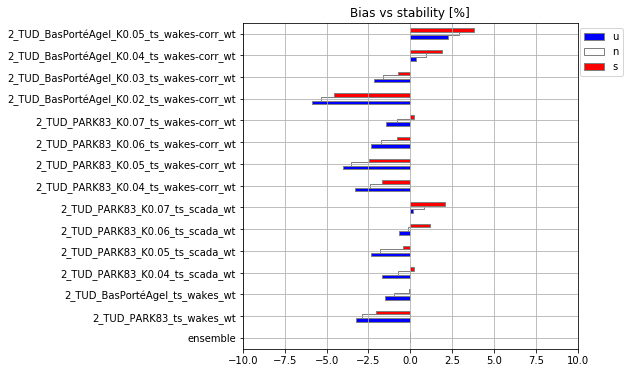

In [75]:
bias_zL = (np.sum(bias[plotresults],axis=1)/len(WDbins)).to_pandas() # bias vs stability [%]
ax = bias_zL.plot.barh(rot=0, grid=1, colormap = 'bwr', edgecolor = 'grey',
                    title='Bias vs stability [%]',figsize=(6,6));
ax.set_yticklabels([sims[tags][x] for x in plotresults]);
ax.set_ylabel('');
ax.legend(bbox_to_anchor=(1.15, 1)); # try stacked=True in the barh options 
ax.set_xlim([-10,10]); # use this to leave outliers out

#bias_zL # uncomment to show table

Integrate along stability to obtain metrics dependency on wind direction


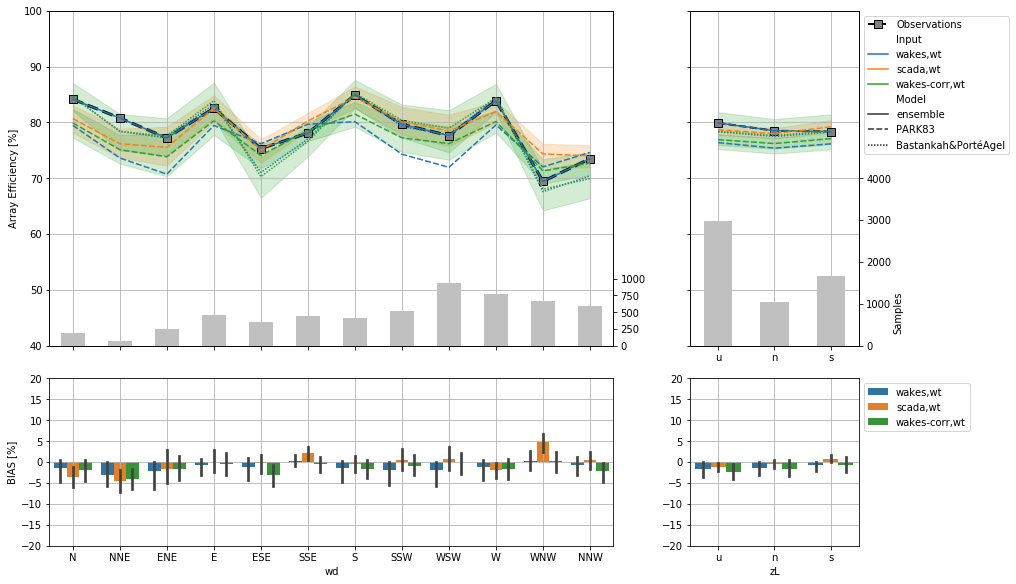

In [76]:
plot_eta_WD_zL(sims, plotresults, sim_eta, bias, bench_eta, N_WDzL_speed, validation);

## Wind turbine metrics

Select a simulation and compare with the reference dataset (observations or another simulation).
* $BIAS_{obs}$ in front row of turbines indicative of *BIAS* in mesoscale inflow

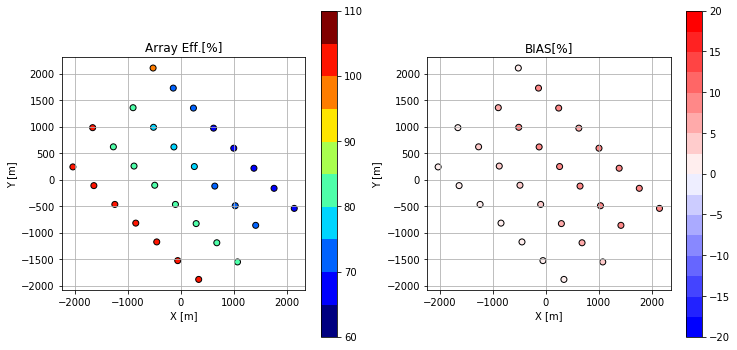

In [77]:
sim = 'orm01b' # select simulation to plot
WDbin = 'WSW' # select wind direction sector
zLbin = 'u'   # select stability

data = [sim_eta_wt.loc[sim,:,WDbin,zLbin].to_pandas(),
        bias_wt.loc[sim,:,WDbin,zLbin].to_pandas()]
plot_wf_layout(turbines['X coordinate']-x_ref, turbines['Y coordinate']-y_ref,data = data,vmin = [60,-20],vmax = [110,20])

**Plot a transect, for chosen bin and wind turbines list**

Here you can choose a wind direction and stability bin and analyze how the net power changes along a given transect of turbines, $P_i$, normalized with respect to a reference position $P_0$. Hence, the **net power ratio** is defined as: 

$$ NPR_0 = \frac{P_i}{P_0} $$

This includes the variation of wind resource across the wind farm, which we characterized with a mesoscale simulation, as well as the wake effects that have been computed by microscale models.   

In contrast, the **gross power ratio** is defined in terms of the theoretical power of a "free-stream" wind turbine, operating at the background (mesoscale) wind speed $S_i$, computed through the power curve $P(S_i)$. 

$$ GPR_0 = \frac{P(S_i)}{P(S_0)} $$

The reference position has traditionaly been the first turbine in a transect aligned with the wind direction to visualize the power deficit with respect to freestream conditions. We can also use the centroid *ref* position to compute a direction-independent $P_0$ that corresponds to the average of the power from all turbines.

$$ P_0 = \frac{\sum_{i}P_i}{N_{wt}} $$

This bin has 174.0 samples


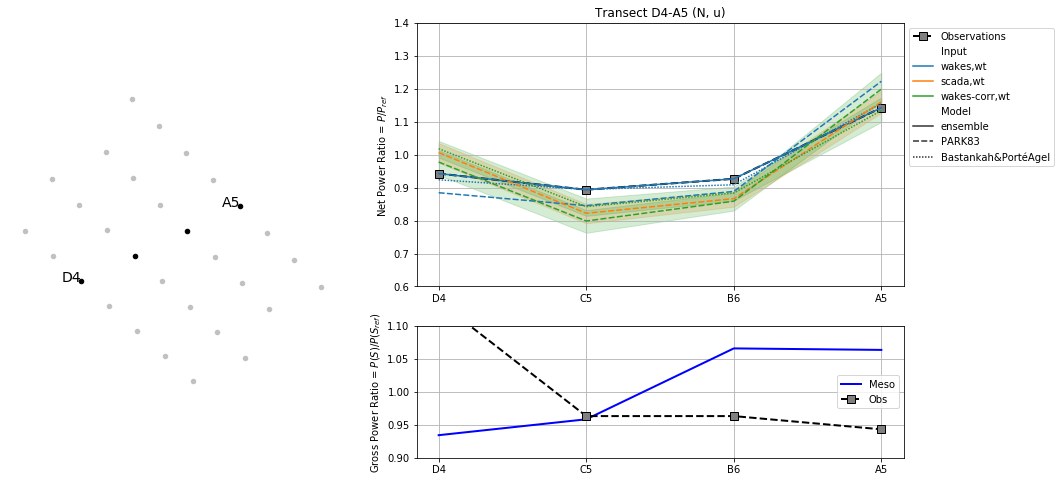

In [78]:
WDbin = 'N'
zLbin = 'u'

# WSW transect
wt_list = ['D4','C5','B6','A5']

# Plot net power ratio
data =   sim_P.loc[:,:,WDbin,zLbin].to_pandas()
val_data = bench_P.loc[:,WDbin,zLbin].to_pandas()
meso_data = meso_P.loc[:,WDbin,zLbin].to_pandas()
obsPfree_data = obs_Pfree.loc[:,WDbin,zLbin].to_pandas()

ylim1 = [0.6,1.4] # y-axis limits for net power ratio
ylim2 = [0.9,1.1] # y-axis limits for gross power ratio
figsize = (16,8) 
wtnorm = 'ref'     # reference position to compute power ratios 
                  #(= 'ref' for mean wind farm power to have the same reference for all plots)

plot_transect(data,val_data,meso_data,obsPfree_data,wt_list,turbines,Drot,
              sims,plotresults,WDbin,zLbin,highlight,ylim1,ylim2,figsize,wtnorm, validation);
print('This bin has {} samples'.format(N_WDzL_speed.loc[WDbin,zLbin]))

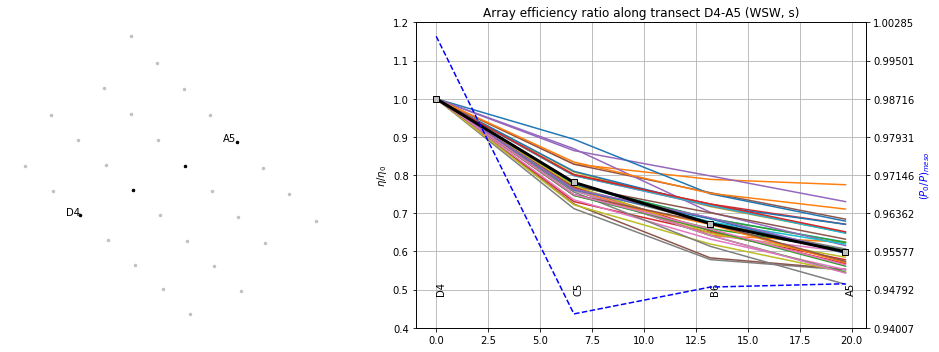

In [79]:
sim_name =  sims['ID'].values

WDbin = 'WSW'
zLbin = 's'

# WSW transect
wt_list = ['D4','C5','B6','A5']

# for list of turbines and wd, 2D plot Value per distance in rotor diameter. 
data =   sim_eta_wt.loc[:,:,WDbin,zLbin].to_pandas()
val_data = bench_eta_wt.loc[:,WDbin,zLbin].to_pandas()
val_data_std = bench_eta_std_wt.loc[:,WDbin,zLbin].to_pandas()
meso_data = meso_P.loc[:,WDbin,zLbin].to_pandas()

plot_transect_old(data,val_data,meso_data,wt_list,turbines,Drot,sim_name,WDbin,zLbin);

(-0.15000000000000002, 3.15)

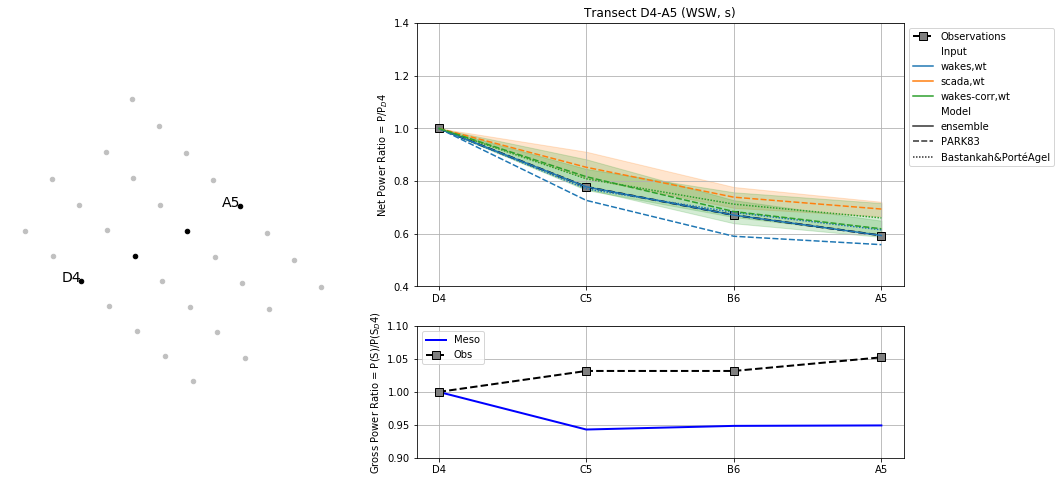

In [80]:
WDbin = 'WSW'
zLbin = 's'

# WSW transect
wt_list = ['D4','C5','B6','A5']

# Plot net power ratio
data =   sim_P.loc[:,:,WDbin,zLbin].to_pandas()
val_data = bench_P.loc[:,WDbin,zLbin].to_pandas()
meso_data = meso_P.loc[:,WDbin,zLbin].to_pandas()
obsPfree_data = obs_Pfree.loc[:,WDbin,zLbin].to_pandas()

ylim1 = [0.4,1.4] # y-axis limits for net power ratio
ylim2 = [0.9,1.1] # y-axis limits for gross power ratio
figsize = (16,8) 
wtnorm = 'D4'     # reference position to compute power ratios 
                  #(= 'ref' for mean wind farm power to have the same reference for all plots)

# Normalize based on wtnorm position
if wtnorm == 'ref':
    datanorm = data[wt_list].div(data.mean(axis = 1), axis=0)
    valdatanorm = val_data[wt_list].div(val_data.mean())
else:
    datanorm = data[wt_list].div(data[wtnorm], axis=0)
    valdatanorm = val_data[wt_list].div(val_data[wtnorm].mean())

datanorm = datanorm.loc[sims['ID'][plotresults]] # plot only these simulations
datanorm.reset_index(level=0, inplace=True)
datanorm_sns = pd.melt(datanorm, id_vars=['sim'], value_vars=wt_list)
datanorm_sns.rename(columns={'value':'P'}, inplace=True)
datanorm_sns['Input'] = 'wakes' # initialize
datanorm_sns['K'] = 0           # initialize
datanorm_sns['Model'] = 'model' # initialize 
for isim in range(len(plotresults)):
    datanorm_sns.loc[datanorm_sns['sim']==sims['ID'][plotresults[isim]],'Input'] = sims['Input'][plotresults[isim]]
    datanorm_sns.loc[datanorm_sns['sim']==sims['ID'][plotresults[isim]],'K'] = sims['Remarks'][plotresults[isim]].partition('K = ')[2]
    datanorm_sns.loc[datanorm_sns['sim']==sims['ID'][plotresults[isim]],'Model'] = sims['Model Type'][plotresults[isim]]

n_wt = len(wt_list)

#compute distances to first turbine
a = turbines.loc[turbines['VDC ID'] == wt_list[0],['X coordinate','Y coordinate']].values.flatten()            
dists = []
coords = np.zeros((n_wt,2))
for wt in range(n_wt):
    b = turbines.loc[turbines['VDC ID'] == wt_list[wt],['X coordinate','Y coordinate']].values.flatten()
    dists.append(((a[0]-b[0])**2+(a[1]-b[1])**2)**0.5 / Drot)
    coords[wt,:]=b

f1 = plt.figure(figsize = figsize)   # constrained_layout=True
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=f1, width_ratios=[1, 1.5], height_ratios=[2, 1])    

iwt = [x in wt_list for x in turbines['VDC ID']]
f1_ax1 = f1.add_subplot(spec[:, 0])
f1_ax1.scatter(turbines['X coordinate'],turbines['Y coordinate'],c='silver', marker = 'o', s=20)
f1_ax1.scatter(turbines['X coordinate'][iwt],turbines['Y coordinate'][iwt],c='black', marker = 'o',s=20)
f1_ax1.text(coords[0][0],coords[0][1],wt_list[0],{'ha': 'right'}, fontsize=14)
f1_ax1.text(coords[-1][0],coords[-1][1],wt_list[-1],{'ha': 'right'}, fontsize=14)
f1_ax1.axis('scaled')
f1_ax1.spines['top'].set_visible(False)
f1_ax1.spines['bottom'].set_visible(False)
f1_ax1.spines['left'].set_visible(False)
f1_ax1.spines['right'].set_visible(False)
f1_ax1.get_xaxis().set_ticks([])
f1_ax1.get_yaxis().set_ticks([])

f1_ax2 = f1.add_subplot(spec[0, 1])
if validation:
    valdatanorm.plot(marker='s', markerfacecolor='grey', linewidth = 2, markeredgecolor= 'k', 
                     markersize = 8, color = 'k', linestyle='--', ax = f1_ax2, label = 'Observations')
f1_ax2 = sns.lineplot(x='wt', y='P', hue='Input', style = 'Model', data=datanorm_sns, sort=False) 
f1_ax2.set_xticklabels(wt_list)
f1_ax2.legend(loc = 'upper left', bbox_to_anchor=(1, 1)) 
f1_ax2.set_ylim(ylim1)
f1_ax2.set_xlabel(None)
if wtnorm == 'ref':
    f1_ax2.set_ylabel('Net Power Ratio = $P/P_{ref}$')  
else:
    f1_ax2.set_ylabel('Net Power Ratio = P/P$_{}$'.format(wtnorm))  
f1_ax2.set_title('Transect '+wt_list[0]+'-'+wt_list[-1]+' ('+WDbin+', '+zLbin+')')
f1_ax2.grid(True)
f1_ax2.margins(0.05)

meso_P_ratio = meso_data.reindex(wt_list)
if wtnorm == 'ref':
    meso_P0 = meso_data.mean()
else:
    meso_P0 = meso_data.loc[wtnorm]
meso_P_ratio = meso_P_ratio/meso_P0

if validation: 
    obs_Pfree_ratio = obsPfree_data.reindex(wt_list)
    if wtnorm == 'ref':
        obs_Pfree_P0 = obsPfree_data.mean()
    else:
        obs_Pfree_P0 = obsPfree_data.loc[wtnorm]
    obs_Pfree_ratio = obs_Pfree_ratio/obs_Pfree_P0

f1_ax3 = f1.add_subplot(spec[1, 1])
f1_ax3.plot(wt_list,meso_P_ratio,'-b',linewidth = 2,label = 'Meso')
if validation:
    f1_ax3.plot(wt_list,obs_Pfree_ratio,marker='s', markerfacecolor='grey', linewidth = 2,
                markeredgecolor= 'k',  markersize = 8, color = 'k', linestyle='--', label = 'Obs')
if wtnorm == 'ref':
    f1_ax3.set_ylabel('Gross Power Ratio = $P(S)/P(S_{ref})$') 
else:
    f1_ax3.set_ylabel('Gross Power Ratio = P(S)/P(S$_{}$)'.format(wtnorm))    

f1_ax3.legend() #loc = 'upper left', bbox_to_anchor=(1, 1)
f1_ax3.grid(True)
f1_ax3.set_ylim(ylim2)

xlim = f1_ax3.get_xlim()
f1_ax2.set_xlim(xlim)

## Save Results

In [81]:
saveresults = False
resultspath = './results/'
siteID = 'orm'

if not benchmark:
    if (Am == 1).all()  & (AsAm == 1).all():
        filename = 'NoMesoCorrection'
    elif (Am == 1).all() & (not (AsAm == 1).all()):
        filename = 'LocalMesoCorrection'
    else:
        filename = 'GlobalMesoCorrection'
else:
    filename = 'blind'
    
if saveresults == True:
    sims.to_csv(resultspath + siteID + '_sims.csv')
    # Global Metrics
    bins_label = []       # labels for each bin in column format 
    for i in WDbins_label:
        for j in zLbins_label:
            bins_label.append(i+j)

    results_bias = pd.DataFrame(columns = bins_label, index = sims.index)
    results_mae = pd.DataFrame(columns = bins_label, index = sims.index)
                       
    for index, row in results_bias.iterrows():
        results_bias.loc[index] = bias[index].values.reshape(1,len(WDbins_label)*len(zLbins_label))
    for index, row in results_mae.iterrows():
        results_mae.loc[index] = mae[index].values.reshape(1,len(WDbins_label)*len(zLbins_label))

    results_bias = pd.concat([sims, Metrics['BIAS[%]'], results_bias],axis=1)
    results_mae = pd.concat([sims, Metrics['MAE[%]'], results_mae],axis=1)

    results_bias.to_csv(resultspath + siteID + '_' + filename + '_bias.csv')
    results_mae.to_csv(resultspath + siteID + '_' + filename + '_mae.csv')

NameError: name 'AsAm' is not defined